# Table Header Detection

## Requirements
- Conda or pip
- MongoDB instance
- PyMongo (will be installed by the notebook)

In [32]:
#import sys
#!conda install --yes --prefix {sys.prefix} pymongo
#!conda install --yes --prefix {sys.prefix} premailer

#!{sys.executable} -m pip install numpy --upgrade
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install cssutils
#!{sys.executable} -m pip install premailer
#!{sys.executable} -m pip install python-crfsuite

import os
import json
import re
import pandas as pd
from pymongo import MongoClient
import requests
from bs4 import BeautifulSoup
from bs4.element import Tag
from cssutils import parseStyle
from premailer import Premailer
import time
from dateutil.parser import parse
from datetime import datetime
import math
import pycrfsuite
from sklearn.model_selection import train_test_split


## Loading the seed data into mongoDB
- initial dataset [Wikipedia TabEL dataset](http://websail-fe.cs.northwestern.edu/TabEL/)
- dataset is lacking of some styling information
- we're crawling the wikipedia pages on our own
  - that should be feasible since we have to use labeled data only (both for training & testing)
  - we're taking the TabEL dataset pageID's as starting point, since we know that there should be at least one relational table

Each line of the TabEL dataset contains one JSON object representing a single table. However, the JSON objects are not contained within a JSON array. We need to wrap the single tables into an array first before we can parse the file as a whole.

In [ ]:
def wrapJSONObjectLineIntoTable(inputFilePath, outputFilePath):
    inputFile = open(inputFilePath, 'r')
    outputFile = open(outputFilePath, 'w')

    outputFile.write('[')

    previousLine = False
    for tableLineJsonObject in inputFile:
        if (previousLine):
            outputFile.write(previousLine + ',')
        previousLine = tableLineJsonObject
    if (previousLine):
        outputFile.write(previousLine)

    outputFile.write(']')

    inputFile.close()
    outputFile.close()

Check if TabEL dataset has been transformed into an array before. If not, we want to parse it now.

In [ ]:
inputFilePath = os.path.join('data', 'wikipedia_0_50000.json')
outputFilePath = os.path.join('data', 'wikipedia_0_50000_fixed.json')
if not os.path.isfile(outputFilePath):
    wrapJSONObjectLineIntoTable(inputFilePath, outputFilePath)

Parse JSON Array

In [ ]:
tabEL = pd.read_json(os.path.join('data', 'wikipedia_0_50000_fixed.json'))
tabEL.head()

Get 1000 unique page IDs and fetch the HTML content for it. (Update: We skip selecting only 1000 here, since we want a broader selection of pages/ tables.)

In [ ]:
uniquePageIDs = pd.DataFrame(tabEL['pgId'].unique(), columns=['pgId'])
print('Number of pages: ' + str(uniquePageIDs.shape[0]))

In [ ]:
def pickRandomSample():
    pageIDSample = uniquePageIDs.sample(n=1000)
    pageIDSample.reset_index(inplace=True)
    pageIDSample.drop(axis='columns', labels='index', inplace=True)

# pickRandomSample()

pageIDSample = uniquePageIDs
pageIDSample.head()

## Crawl the wikipedia pages and fetch all occurring tables
We use the pageID's from the TabEL dataset and crawl the wikipedia html. One page might include multiple tables. We only extract HTML tables with the class `wikitable`. The style from the CSS file gets parsed into inline style.

In [ ]:
BASE_URL = 'https://en.wikipedia.org'
wikipediaCSSFilePath = os.path.join('data', 'wikipedia.css')
cssFilePath = os.path.join('data', 'wikipedia.css')
cssFile = open(cssFilePath, 'r')
css = cssFile.read()
instance = Premailer(
    base_url=BASE_URL,
    exclude_pseudoclasses=False,
    include_star_selectors=True,
    disable_validation=True,
    css_text=css,
    allow_network=False,
    cssutils_logging_level='CRITICAL'
)

def crawl(tabEL):
    print(tabEL.name)
    payload = { 'curid': str(tabEL['pgId']) }
    html = requests.get(BASE_URL, params=payload).text
    htmlWithInlineCSS = instance.transform(str(html))
    return htmlWithInlineCSS

In [ ]:
client = MongoClient()
db = client.bob
pages = db.pages

def batchCrawl():
    pageIDSample['HTML'] = pageIDSample.apply(crawl, axis='columns')
    pageIDSample['HTML'] = pageIDSample['HTML'].str.replace('\n', '')
    pageIDSample['HTML'] = pageIDSample['HTML'].str.replace('\t', '')
    pages.insert_many(pageIDSample.to_dict('records'))
    # pageIDSample.to_json(os.path.join("data", "crawled.json"))
    client.close()

def sequenceCrawl():
    for index, row in pageIDSample.iterrows():
        inlineHTML = crawl(row)
        inlineHTML = inlineHTML.replace('\n', '')
        inlineHTML = inlineHTML.replace('\t', '')
        row['HTML'] = inlineHTML
        pages.insert_one(row.to_dict())
    client.close()

print('Begin time: ' + str(datetime.now()))
sequenceCrawl()

In [ ]:
client = MongoClient()
db = client.bob
pages = db.pages
pages.insert_many(pageIDSample.to_dict('records'))
# pageIDSample.to_json(os.path.join("data", "crawled.json"))
client.close()

In [ ]:
client = MongoClient()
db = client.bob
pages = db.pages
cursor = pages.find({})
pageIDSample = pd.DataFrame(list(cursor))
client.close()

In [ ]:
pageIDSample.head()

Now we extract the tables along with some metadata. For each row we assign an unique ID (the index of the row within the table) and a tag (whether the row includes `th-tags` only or is contained within a `thead`)

In [ ]:
HEADLINE_PATTERN = re.compile('(h|H)\d')
LABEL_CONTROLS = [
    {
        'label': 'Header',
        'color': 'light-blue'
    }, {
        'label': 'Data',
        'color': 'lime'
    }, {
        'label': 'Other',
        'color': 'orange'
    }
];

def extractPageTitle(soup):
    headlines = soup.select('h1')
    return headlines[0].text if len(headlines) > 0 else 'N/A'

def extractTableTitle(table):
    for sibling in table.previous_siblings:
        if (sibling is not None and sibling.name is not None and HEADLINE_PATTERN.match(sibling.name)):
            return sibling.text
    return 'N/A'

def addLabelControls(row, rowIndex, soup):
    labelControlTag = soup.new_tag(
        'th',
        attrs={
            'class': 'flex space-evenly'
        }
    )
    for labelControl in LABEL_CONTROLS:
        labelControlButton = soup.new_tag(
            'a',
            attrs={
                'class': 'labelButton waves-effect waves-light btn-small ' + labelControl['color'],
                'onClick': 'annotate(' + str(rowIndex) + ', "' + labelControl['label'] + '");',
            }
        )
        labelControlButton.string = labelControl['label']
        labelControlTag.append(labelControlButton)
    row.insert(0, labelControlTag)
    
def tagRow(row, rowIndex, soup, isHead=False):
    row['data-label'] = 'Header' if isHead else 'Data'
    row['data-row-index'] = rowIndex
    addLabelControls(row, rowIndex, soup)
    
def isHeaderRow(row):
    thTags = row.find_all('th', recursive=False)
    childCount = len(row.contents)
    return childCount == len(thTags) or row.parent.name == 'thead'

def tagRows(table, soup):
    rows = table.find_all('tr')
    annotations = []
    for rowIndex, row in enumerate(rows):
        isHeader = isHeaderRow(row)
        tagRow(row, rowIndex, soup, isHeader)  
        annotations.append('Header' if isHeader else 'Data')
    return annotations

def removeTableWidthLimitation(table):
    if not table.has_attr('style'):
        return
    tableStyle = parseStyle(table['style'])
    tableStyle['width'] = '100%'
    tableStyle['font-size'] = '100%'
    table['style'] = tableStyle.cssText
        
def extractTableInformation(table, pageID, tableIndex, pageTitle, soup):
    extractedInformation = {
        'pageID': pageID,
        'tableIndex': tableIndex,
        'pageTitle': pageTitle
    }
    extractedInformation['html'] = table.prettify()
    annotations = tagRows(table, soup)
    removeTableWidthLimitation(table)
    extractedInformation['taggedHtml'] = table.prettify()
    extractedInformation['annotations'] = annotations
    extractedInformation['tableTitle'] = extractTableTitle(table)
    return extractedInformation

def hasNestedTable(table):
    return len(table.select('table')) > 0

def extractTables(page):
    soup = BeautifulSoup(page['HTML'])
    pageTitle = extractPageTitle(soup)
    wikiTables = soup.select('table.wikitable')
    extractedTables = []
    for tableIndex, table in enumerate(wikiTables):
        if hasNestedTable(table):
            continue
        extractedTable = extractTableInformation(table, page['pgId'], tableIndex, pageTitle, soup)
        extractedTables.append(extractedTable)
    return extractedTables

In [ ]:
client = MongoClient()
db = client.bob
tables = db.tables
for extractedTables in pageIDSample.apply(extractTables, axis='columns').values:
    if len(extractedTables) > 0:
        tables.insert_many(extractedTables)
client.close()

The data can now get labeled using the provided [labeling tool](https://github.com/RichStone/web-tables-header-detection/tree/master/Labeling%20Tool). However, we may use the feature extraction to enhance the table selection process.

# Feature Extraction

In [15]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({})
tables = pd.DataFrame(list(cursor))
client.close()

In [18]:
tables.head()

,_id,annotatedAt,annotations,features,html,pageID,pageTitle,skipped,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isNumeric': 0, 'isBold': 0, 'isCenterA...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...",10002196,Got to Have Your Love,NaN,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isNumeric': 0, 'isBold': 0, 'isCenterA...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",1000141,Thales (crater),NaN,0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isShortText': 1, 'isNumeric': 0, 'isBo...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...",1000102,1977 Manitoba general election,NaN,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isNumeric': 0, 'isBold': 0, 'isCenterA...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...",100039,Clarence Nash,NaN,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isNumeric': 0, 'isBold': 1, 'isCenterA...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",100040,Richmond Football Club,NaN,6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [19]:
SHORT_TEXT_THRESHOLD = 20
LONG_TEXT_THRESHOLD = 255

def isInt(value):
    try: 
        int(value)
        return True
    except ValueError:
        return False
    
def getRowSpan(cell):
    if cell.has_attr('rowspan') and isInt(cell['rowspan']):
        return int(cell['rowspan'])
    return 1
    
def getColSpan(cell):
    if cell.has_attr('colspan') and isInt(cell['colspan']):
        return int(cell['colspan'])
    return 1

def isMerged(cell):
    return (
        getColSpan(cell) > 1 or
        getRowSpan(cell) > 1
    )

def isCenterAligned(cell, style):
    return (
        (cell.has_attr('align') and cell['align'] == 'center') or
        (style is not None and 'text-align' in style and style['text-align'] == 'center')
    )

def isThOrInTHead(cell):
    row = cell.parent
    rowParent = row.parent
    return (
        cell.name == 'th' or
        rowParent.name == 'thead'
    )

def extractLayoutFeatures(cell, style):
    return {
        'isMerged': isMerged(cell),
        'isCenterAligned': isCenterAligned(cell, style),
        'isTHOrInTHead': isThOrInTHead(cell)
    }

def isBold(cell, style):
    return bool(
        style is not None and (
            style['font-weight'] == 'bold' or 
            style['font-style'] == 'bold'
        ) or
        cell.find('b') or
        cell.find('strong')
    )

def isItalic(cell, style):
    return bool(cell.find('i'))

def isUnderlined(cell, style):
    return bool(
        cell.find('u') or
        style is not None and (
            style['text-decoration'] == 'underline' or
            style['font-style'] == 'bold'
        )
    )

def isColored(cell, style):
    return (
        style is not None and (
            'background-color' in style or
            'color' in style
        )
    )

def extractStyleFeatures(cell, style):
    return {
        'isBold': isBold(cell, style),
        'isItalic': isItalic(cell, style),
        'isUnderlined': isUnderlined(cell, style)
    }

def getCellStyle(cell):
    return parseStyle(cell['style']) if cell.has_attr('style') else None

def getContentLength(cell):
    return len(re.sub('\s+',' ', cell.get_text()).split())

def isEmpty(cell):
    return getContentLength(cell) == 0

def isText(cell):
    return cell.get_text().isalpha()

def isNumeric(cell):
    return cell.get_text().isdigit()

def isDate(cell):
    try: 
        parse(cell.get_text(), fuzzy=False)
        return True
    except (ValueError, OverflowError):
        return False
    
def isShortText(cell):
    return getContentLength(cell) <= SHORT_TEXT_THRESHOLD

def isLongText(cell):
    return getContentLength(cell) > LONG_TEXT_THRESHOLD

def isTotal(cell):
    return cell.get_text().lower() == 'total'

def extractValueFeatures(cell):
    return {
        'isEmpty': isEmpty(cell),
        'isText': isText(cell),
        'isNumeric': isNumeric(cell),
        'isDate': isDate(cell),
        'isShortText': isShortText(cell),
        'isLongText': isLongText(cell),
        'isTotal': isTotal(cell)
    }

def mapDictBoolValuesToInt(dictionary):
    return { key: int(value) for key, value in dictionary.items() }

def applyColSpanFactor(dictionary, colSpan):
    return { key: value * colSpan for key, value in dictionary.items() }

def merge(featuresA, featuresB):
    return { k: featuresA.get(k, 0) + featuresB.get(k, 0) for k in set(featuresA) | set(featuresB) }

def stringifyDictKeys(dictionary):
    return { str(key): value for key, value in dictionary.items() }

def numNormalisedCols(row):
    numCols = 0
    for cell in row.children:
        if type(cell) is Tag:
            numCols += getColSpan(cell)
    return numCols
            
def getSimilarity(feature, cell, neighbour, suffix):
    similarity = {}
    similarity[feature + 'A' + suffix] = cell[feature] and neighbour[feature]
    similarity[feature + 'B' + suffix] = cell[feature] and not neighbour[feature]
    return similarity
    
def extractSimilarityFeatures(cell, neighbour, suffix, featureNames):
    similarityFeatures = {}
    for feature in featureNames:
        similarityFeatures = {
            **getSimilarity(feature, cell, neighbour, suffix),
            **similarityFeatures
        }
    return similarityFeatures   
    
def getRowSimilarityFeatures(normalizedFeatureTable, rowIndex, row):
    newRow = []
    numRows = len(normalizedFeatureTable)
    for cellIndex, cell in enumerate(row):
        features = cell
        featureNames = [key for key in features]
        if rowIndex > 0:
            features = {
                **extractSimilarityFeatures(cell, normalizedFeatureTable[rowIndex - 1][cellIndex], 'u', featureNames), 
                **features
                }
        if rowIndex < numRows - 1:
            features = {
                **extractSimilarityFeatures(cell, normalizedFeatureTable[rowIndex + 1][cellIndex], 'l', featureNames),
                **features
            }
        intCellFeatures = mapDictBoolValuesToInt(features)
        newRow.append(intCellFeatures)
        return newRow
    
def addSimilarityFeatures(normalizedFeatureTable):
    normalizedTableWithSimilarity = []
    for rowIndex, row in enumerate(normalizedFeatureTable):
        newRow = getRowSimilarityFeatures(normalizedFeatureTable, rowIndex, row)
        normalizedTableWithSimilarity.append(newRow)        
    return normalizedTableWithSimilarity
    
def cleanOfEmptyCells(table):
    lastEmptyCellIndex = len(table[0])
    for row in table:
        for cellIndex,cell in enumerate(row):
            if cell == 'empty cell':
                lastEmptyCellIndex = min(lastEmptyCellIndex, cellIndex)
    newTable =[]
    for row in table:
        newTable.append(row[:lastEmptyCellIndex])
    return newTable

def getBoolCellFeatures(cell):
    cellStyle = getCellStyle(cell)
    boolCellFeatures = {
        **extractLayoutFeatures(cell, cellStyle),
        **extractStyleFeatures(cell, cellStyle),
        **extractValueFeatures(cell)
    }
    boolCellFeatures['colCount'] = 1
    return boolCellFeatures

def fillNormalizedFeatureTable(rows, numRows, numCols):
    normalizedTable = [['empty cell' for i in range(numCols)] for j in range(numRows)]
    for rowIndex, row in enumerate(rows):
        cellIndex = 0
        for cell in row.children:
            if type(cell) is not Tag:
                continue
            boolCellFeatures = getBoolCellFeatures(cell)
            # normalize
            colSpan = getColSpan(cell)
            rowSpan = getRowSpan(cell)
            # find the position of the cell
            while cellIndex < numCols and normalizedTable[rowIndex][cellIndex] != 'empty cell':
                cellIndex += 1
            for rIndex in range(rowIndex, min(rowIndex + rowSpan, numRows)):
                for cIndex in range(cellIndex, min(cellIndex + colSpan, numCols)):
                    normalizedTable[rIndex][cIndex] = boolCellFeatures
            cellIndex += colSpan
    return normalizedTable
        
def normalizedFeatureTable(table):
    soup = BeautifulSoup(table['html'])
    rows = soup.select('tr')
    # initialize normalized feature table
    numRows = len(rows)
    numCols = numNormalisedCols(rows[0])
    normalizedTable = fillNormalizedFeatureTable(rows, numRows, numCols)
    normalizedTable = cleanOfEmptyCells(normalizedTable)
    return addSimilarityFeatures(normalizedTable)    
            
def extractFeatures(table):
    featureTable = normalizedFeatureTable(table)
    rowFeatureTable = {}
    for rowIndex, row in enumerate(featureTable):
        # count how often every feature is true in a row
        rowFeatures = {}
        for cellFeatures in row:
            rowFeatures = merge(rowFeatures, cellFeatures)
        rowFeatureTable[rowIndex] = rowFeatures
    rowFeatureTable = stringifyDictKeys(rowFeatureTable)
    return rowFeatureTable

In [20]:
tables['features'] = tables.apply(extractFeatures, axis='columns')
tables.head()

WARNING	Property: Unknown Property name. [1:121: text-style]
WARNING	Property: Unknown Property name. [1:121: text-style]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:116: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:116: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:110: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:116: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:116: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	Property: Unknown Property name. [1:110: -webkit-box-shadow]
WARNING	Property: Unknown Property name. [1:48: -moz-box-shadow]
WARNING	P

,_id,annotatedAt,annotations,features,html,pageID,pageTitle,skipped,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...",10002196,Got to Have Your Love,NaN,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",1000141,Thales (crater),NaN,0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...",1000102,1977 Manitoba general election,NaN,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...",100039,Clarence Nash,NaN,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",100040,Richmond Football Club,NaN,6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [21]:
client = MongoClient()
db = client.bob
tablesCollection = db.tables
dictTables = tables.to_dict('records')
for table in dictTables:
    tablesCollection.replace_one({'_id': table['_id']}, table, True)
client.close()

## Select Tables for Labeling
70% of all tables are considered 'simple'. We don't want to spend too much time labeling only simple tables. We wan't to have more interesting tables and are therefor making a thoughtful selection of tables.
Goal: 1000 Tables in total, where ideally 250 are randomly selected, 250 have no header, 250 have at least one merged cell and 250 tables that do have bold cells which are not located in the header.

In [22]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({})
tables = pd.DataFrame(list(cursor))
client.close()

In [23]:
tables = tables.loc[lambda tables: tables['features'].apply(lambda features: len(features) > 1)]
print('Amount of tables with row count greater 1: ' + str(tables.shape[0]))

Amount of tables with row count greater 1: 1000


In [ ]:
def hasTableAHeader(tableFeatures):
    for rowIndex, rowFeatures in tableFeatures.items():  
        if (rowFeatures['isTHOrInTHead'] > 0):
            return True
    return False

tablesWithNoHeader = tables.loc[lambda tables: tables['features'].apply(lambda features: not hasTableAHeader(features))]
print('Amount of tables without a header: ' + str(tablesWithNoHeader.shape[0]))

In [ ]:
def hasBoldStyleOutsideHead(tableFeatures):
    for rowIndex, rowFeatures in tableFeatures.items():  
        if (rowFeatures['isBold'] > 0 and rowFeatures['isTHOrInTHead'] == 0):
            return True
    return False

tablesWithBoldStyleOutsideHead = tables.loc[lambda tables: tables['features'].apply(hasBoldStyleOutsideHead)]
print('Amount of tables with bold styles outside of header: ' + str(tablesWithBoldStyleOutsideHead.shape[0]))

In [ ]:
def hasMergedCellsOutsideHead(tableFeatures):
    for rowIndex, rowFeatures in tableFeatures.items():  
        if (rowFeatures['isMerged'] > 0 and rowFeatures['isTHOrInTHead'] == 0):
            return True
    return False

tablesWithMergedCellsOutsideHead = tables.loc[lambda tables: tables['features'].apply(lambda features: hasMergedCellsOutsideHead(features))]
print('Amount of tables with merged cells outside of header: ' + str(tablesWithMergedCellsOutsideHead.shape[0]))

In [ ]:
labelTables = tablesWithNoHeader.sample(n=250)

reducedTablesWithMergedCellsOutsideHead = tablesWithMergedCellsOutsideHead.loc[~tablesWithMergedCellsOutsideHead.index.isin(list(labelTables.index))]
labelTables = pd.concat([labelTables, reducedTablesWithMergedCellsOutsideHead.sample(n=250)])

reducedTablesWithBoldStyleOutsideHead = tablesWithBoldStyleOutsideHead.loc[~tablesWithBoldStyleOutsideHead.index.isin(list(labelTables.index))]
labelTables = pd.concat([labelTables, reducedTablesWithBoldStyleOutsideHead.sample(n=250)])

remainingTables = tables.loc[~tables.index.isin(list(labelTables.index))]
labelTables = pd.concat([labelTables, remainingTables.sample(n=250)])
labelTables = labelTables.sample(frac=1).reset_index(drop=True) #shuffle
labelTables.shape[0]

In [ ]:
labelTables1 = labelTables.head(500)
labelTables2 = labelTables.tail(500)

In [ ]:
client = MongoClient()
db = client.bob
labelTables1Collection = db.labelTables1
labelTables1Collection.insert_many(labelTables1.to_dict('records'))
labelTables2Collection = db.labelTables2
labelTables2Collection.insert_many(labelTables2.to_dict('records'))
client.close()

## Logarithmic Binning

In [24]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({})
tables = pd.DataFrame(list(cursor))
client.close()
tables.head()

,_id,annotatedAt,annotations,features,html,pageID,pageTitle,skipped,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...",10002196,Got to Have Your Love,NaN,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",1000141,Thales (crater),NaN,0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...",1000102,1977 Manitoba general election,NaN,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...",100039,Clarence Nash,NaN,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",100040,Richmond Football Club,NaN,6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [25]:
def calcA(c, r):
    if (c == 0):
        return 0
    if (c == r):
        return r
    if (c > r / 2.0):
        return math.floor(math.log2(r - c) + 1)
    return math.floor(math.log2(c) + 1)

def calcB(c, r):
    return math.floor(math.log2(r))

def isInSameBin(rowA, rowB, featureKey):
    return (
        calcB(rowA[featureKey], rowA['colCount']) == calcB(rowB[featureKey], rowB['colCount']) and 
        calcA(rowA[featureKey], rowA['colCount']) == calcA(rowB[featureKey], rowB['colCount'])
    )

def logBinTable(table):
    if len(table['features']) == 0:
        return []
    logBins = {}
    for rowIndex, row in table['features'].items():
        logBin = dict(row)
        colCount = logBin.pop('colCount')
        logBin = { 
            featureKey: { 
                'a': calcA(feature, colCount),
                'b': calcB(feature, colCount)
            } for featureKey, feature in logBin.items() 
        }
        logBins[rowIndex] = logBin
    return logBins

In [26]:
tables['logBin'] = tables.apply(logBinTable, axis='columns')
tables.head()

,_id,annotatedAt,annotations,features,html,pageID,pageTitle,skipped,tableIndex,tableTitle,taggedHtml,logBin
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...",10002196,Got to Have Your Love,NaN,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",1000141,Thales (crater),NaN,0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...",1000102,1977 Manitoba general election,NaN,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...",100039,Clarence Nash,NaN,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...",100040,Richmond Football Club,NaN,6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu..."


In [27]:
client = MongoClient()
db = client.bob
tablesCollection = db.tables
dictTables = tables.to_dict('records')
for table in dictTables:
    tablesCollection.replace_one({'_id': table['_id']}, table, True)
client.close()

## Conditional Random Fields

In [28]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({"annotatedAt" : {"$exists" : True}, "skipped": {"$ne": True}})
tables = pd.DataFrame(list(cursor))
print(len(tables))
client.close()
tables.head()

975


,_id,annotatedAt,annotations,features,html,logBin,pageID,pageTitle,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",10002196,Got to Have Your Love,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",1000141,Thales (crater),0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",1000102,1977 Manitoba general election,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",100039,Clarence Nash,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",100040,Richmond Football Club,6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [33]:
def getCRFFeatures(table):
    tableFeatures = table['logBin']
    tableAnnotations = table['annotations']
    rowFeatures = []
    rowAnnotations = []
    
    for rowIndex in tableFeatures:
        rowFeatures.append(tableFeatures[rowIndex])
        rowAnnotations.append(tableAnnotations[int(rowIndex)])
    tableID = table['_id']
    return (rowFeatures, rowAnnotations, tableID)

tableFeatures = tables.apply(getCRFFeatures, axis='columns')
featureSequence = []
lableSequence = []
for tf in tableFeatures:
    featureSequence.append(tf[0])
    #lableSequence.append(tf[1])
    lableSequence.append((tf[2], tf[1]))

In [34]:
X_train, X_test, y_trainId, y_testId = train_test_split(featureSequence, lableSequence, test_size=0.1)
y_train = [a[1] for a in y_trainId]
y_test = [a[1] for a in y_testId]
testIDs = [a[0] for a in y_testId]

In [35]:
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# params copied from https://github.com/scrapinghub/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

trainer.train('../data/firstTraining.crfsuite')

In [36]:
tagger = pycrfsuite.Tagger()
tagger.open('../data/firstTraining.crfsuite')
y_pred = [tagger.tag(xseq) for xseq in X_test]


In [37]:
tables = db.tables
tables.find
for tableId, predictions in zip(testIDs, y_pred):
    tables.update_one({'_id': tableId}, {'$set': {'predictions': predictions}})

In [38]:
import numpy as np
from sklearn.metrics import classification_report

# Create a mapping of labels to indices
labels = {"Header": 0, "Data": 1, "Other": 2}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["Header", "Data", "Other"]))


              precision    recall  f1-score   support

      Header       0.97      0.95      0.96       117
        Data       0.99      1.00      0.99      1502
       Other       0.98      0.82      0.90        73

   micro avg       0.99      0.99      0.99      1692
   macro avg       0.98      0.92      0.95      1692
weighted avg       0.99      0.99      0.99      1692



# Evaluation

In [39]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({"annotatedAt" : {"$exists" : True}, "skipped": {"$ne": True}})
tables = pd.DataFrame(list(cursor))
client.close()
tables.head()
labledTableCount = len(tables)

In [40]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({"predictions" : {"$exists" : True}})
predictedTables = pd.DataFrame(list(cursor))
client.close()
predictedTables.head()
predictedTableCount = len(predictedTables)

In [41]:
print('Trained on ' + str(labledTableCount))
print('Tested on ' + str(predictedTableCount))

Trained on 975
Tested on 98


In [119]:
def getWronglyPredicted(table):
    incorrect = []
    for rowIndex, label in enumerate(table['annotations']):
        if(label != table['predictions'][rowIndex]):
            incorrect.append({
                'annotated': label,
                'predicted': table['predictions'][rowIndex]
            })
    return incorrect

def getCorrectlyPredictedCount(table):
    return len(table['annotations']) - table['predictedIncorrectlyCount']
    
def isWholeTableCorrectlyPredicted(table):
    return table['predictedCorrectlyCount'] == len(table['annotations'])

def getIncorrectlyPredictedCount(table):
    return len(table['wronglyPredicted'])

In [120]:
predictedTables['wronglyPredicted'] = predictedTables.apply(getWronglyPredicted, axis='columns')
predictedTables['predictedIncorrectlyCount'] = predictedTables.apply(getIncorrectlyPredictedCount, axis='columns')
predictedTables['predictedCorrectlyCount'] = predictedTables.apply(getCorrectlyPredictedCount, axis='columns')
predictedTables['predictedCorrectly'] = predictedTables.apply(isWholeTableCorrectlyPredicted, axis='columns')
predictedTables.head()

,_id,annotatedAt,annotations,features,html,logBin,pageID,pageTitle,predictions,tableIndex,tableTitle,taggedHtml,predictedCorrectly,predictedCorrectlyCount,predictedIncorrectly,predictedIncorrectlyCount,wronglyPredicted
0,5d020c07e7ee03eab39a843f,1.560440e+12,"[Header, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable succ...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",10009503,Xue Ju,"[Header, Data, Data]",0,Personal information[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable succ...",True,3,0,0,[]
1,5d020c08e7ee03eab39a8580,1.560438e+12,"[Header, Data, Data]","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table align=""center"" bgcolor=""#f8f9fa"" class=...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",10017092,Paul Tonkinson,"[Data, Data, Data]",0,Accolades[edit],"<table align=""center"" bgcolor=""#f8f9fa"" class=...",False,2,1,1,"[{'annotated': 'Header', 'predicted': 'Data'}]"
2,5d020c08e7ee03eab39a854e,1.560439e+12,"[Header, Header, Data, Data, Data, Data, Data,...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",1001651,List of minor planets: 88001–89000,"[Header, Header, Data, Data, Data, Data, Data,...",6,88601–88700[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort...",True,102,0,0,[]
3,5d020c08e7ee03eab39a85db,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table align=""center"" bgcolor=""#f8f9fa"" border...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",10018145,Daytime Emmy Award for Outstanding Younger Act...,"[Header, Data, Data, Data, Data, Data, Data, D...",7,Series with most awards[edit],"<table align=""center"" bgcolor=""#f8f9fa"" border...",True,9,0,0,[]
4,5d020c0ce7ee03eab39a882e,1.560440e+12,"[Header, Header, Data, Data, Data, Data, Data,...","{'0': {'isLongTextBl': 0, 'isNumeric': 0, 'isU...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isLongTextBl': {'a': 0, 'b': 0}, 'isNu...",10025719,List of minor planets: 152001–153000,"[Header, Header, Data, Data, Data, Data, Data,...",2,152201–152300[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort...",True,102,0,0,[]


In [121]:
correctlyPredictedTables = predictedTables.loc[predictedTables['predictedCorrectly']].shape[0]
print('Correctly predicted table count: ' + str(correctlyPredictedTables))

Correctly predicted table count: 83


In [122]:
incorrectPredictedTables = predictedTables.loc[~predictedTables['predictedCorrectly']]
incorrectPredictedTables.reset_index(inplace=True)
incorrectPredictedTableCount = incorrectPredictedTables.shape[0]
print('Incorrect predicted table count: ' + str(incorrectPredictedTableCount))

Incorrect predicted table count: 15


In [123]:
def labelBars(plot):
    for p in plot.patches:
        plot.annotate(
            np.round(p.get_height(), decimals=2),
            (
                p.get_x() + p.get_width() / 2.,
                p.get_height()
            ),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points'
     )

[Text(0, 0.5, 'Amount of tables'),
 Text(0.5, 0, 'Amount of incorrectly labeled rows per table'),
 Text(0.5, 1.0, 'Number of tables with same amount of incorrectly labeled rows')]

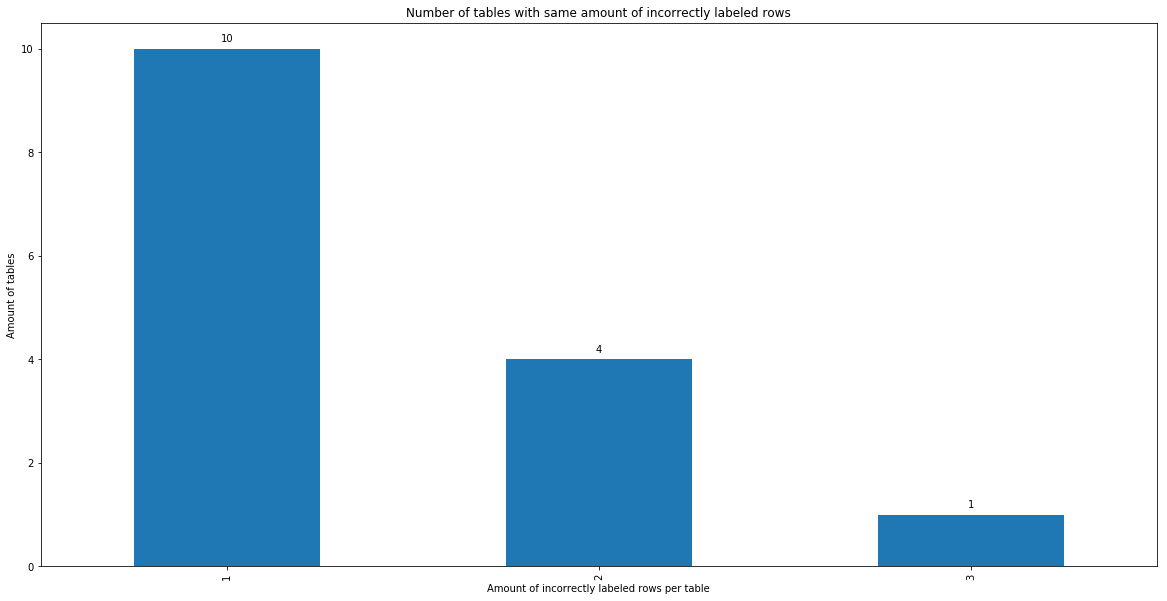

In [124]:
numberOfIncorrectRowsPerTablePlot = incorrectPredictedTables['predictedIncorrectlyCount'].value_counts().plot(
    kind='bar', 
    figsize=(20, 10)
)
labelBars(numberOfIncorrectRowsPerTablePlot)
numberOfIncorrectRowsPerTablePlot.set(
   xlabel='Amount of incorrectly labeled rows per table',
    ylabel='Amount of tables',
    title='Number of tables with same amount of incorrectly labeled rows'
)

[Text(0, 0.5, 'Amount of tables'),
 Text(0.5, 0, 'Tables with specific row count'),
 Text(0.5, 1.0, 'Amount of incorrectly predicted rows per table')]

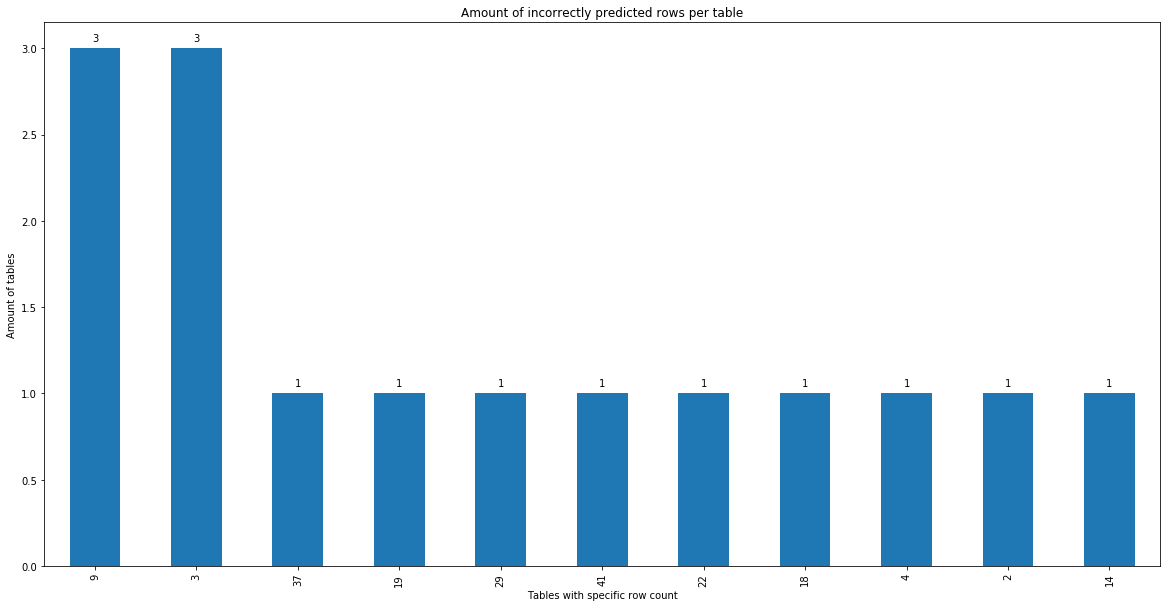

In [134]:
def getRowCount(table):
    return len(table['annotations'])

rowCountPerTablePlot = incorrectPredictedTables.apply(getRowCount, axis='columns').value_counts().plot(
    kind='bar', 
    figsize=(20, 10)
)
labelBars(rowCountPerTablePlot)
rowCountPerTablePlot.set(
   xlabel='Tables with specific row count',
    ylabel='Amount of tables',
    title='Amount of incorrectly predicted rows per table'
)

In [133]:
wronglyPredicted = list(incorrectPredictedTables['wronglyPredicted'])
wronglyPredicted = [item for sublist in wronglyPredicted for item in sublist]
wronglyPredicted = pd.DataFrame(wronglyPredicted)
print('Count of which row type got predicted incorrectly:')
wronglyPredicted.groupby('annotated').count()

Count of which row type got predicted incorrectly:


,predicted
annotated,
Data,2
Header,6
Other,13


In [139]:
print('Table ids of incorrectly predicted tables')
pd.set_option('display.max_colwidth', -1)
incorrectPredictedTables[['_id', 'predictions']]

Table ids of incorrectly predicted tables


,_id,predictions
0,5d020c08e7ee03eab39a8580,"[Data, Data, Data]"
1,5d020c0de7ee03eab39a88ca,"[Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data]"
2,5d020c0fe7ee03eab39a8e10,"[Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data]"
3,5d020c11e7ee03eab39a957a,"[Data, Data]"
4,5d020c11e7ee03eab39a958c,"[Header, Data, Data, Data]"
5,5d020c12e7ee03eab39a9b2c,"[Header, Data, Data, Data, Other, Other, Other, Data, Data]"
6,5d020c14e7ee03eab39aa41a,"[Header, Data, Data]"
7,5d020c14e7ee03eab39aa42f,"[Header, Data, Data, Data, Other, Other, Other, Data, Data]"
8,5d020c18e7ee03eab39aadab,"[Header, Header, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Header, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Other]"
9,5d020c09e7ee03eab39a8600,"[Header, Header, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Data, Other]"


In [98]:
incorrectPredictedTables.apply(getRowCount, axis='columns').value_counts()

9     3
3     3
37    1
19    1
29    1
41    1
22    1
18    1
4     1
2     1
14    1
dtype: int64

## Possible reasons for incorrect labeling:
- background color not taken into account enough -> to less examples where background color indicates Header or to many example where a colored cell is not a Header cell
- It's a legend and marked as data while we would label it as 'Other' -> taking into account the occurrence of characters like '=' ':' could help?
- merged cell doesn't seem to be a good indicator that cell should be 'Other' instead of 'Data'
- group header mistaken as real header
- maybe the tables (with many rows) in the test set had no header and therefor the size was more important? (need to check if row/col count is taken as feature)
- 'bold' style doesn't indicate if it's a header for sure -> tr/thead feature is more important -> if tr/thead is missing, but cell is bold the row still gets marked as 'Data' instead of 'Header' -> introduce feature accross whole row for bold too